In [5]:
from jax.config import config; config.update("jax_enable_x64", True)
from jax.random import PRNGKey, split

import matplotlib.pyplot as plt

from collapse import compute_feature_collapse
from network import init_net_orth, compute_outputs
from loss import create_loss
from solver import train
from data import generate_orthogonal_input, generate_labels_and_target

In [6]:
key = PRNGKey(0)

num_classes = 5
num_samples_per_class = 10
total_samples = num_classes * num_samples_per_class
input_dim = total_samples

labels, target = generate_labels_and_target(num_classes, num_samples_per_class)

key, subkey = split(key)
input_data = generate_orthogonal_input(subkey, input_dim, total_samples)

nonlinear = True
depth = 5
init_scale = 1e-1

loss_fn = create_loss(target)
def e2e_loss_fn(weights):
    return loss_fn(compute_outputs(weights, input_data, nonlinear)[0])

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=num_classes, 
    width=input_dim, 
    depth=depth, 
    init_scale=init_scale
)

In [7]:
tol = 1e-8
step_size = 1
n_outer_loops = 5000
n_inner_loops = 100

step_size = step_size
result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops
)

final_weights = result['final_weights']

  0%|          | 0/5000 [00:00<?, ?it/s]

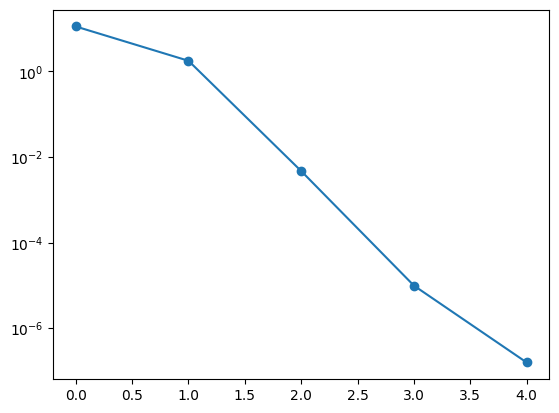

In [8]:
intermediate_outputs = compute_outputs(final_weights, input_data, nonlinear=nonlinear)[1]

feature_collapse_per_layer = [
    compute_feature_collapse(inter_out, labels) for inter_out in intermediate_outputs
]

plt.semilogy(feature_collapse_per_layer, '-o')